# Auto-encoder Segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%bash
# Unzip dataset folder
unzip -q ./drive/MyDrive/Computer\ Vision/Dataset.zip || echo 'Dataset already unzipped or not found.'

# **Computer Vision Project**

Authors:
- Julia Lopez Gomez
- Benjamin Henriquez Soto

In [25]:
import os
import random
import numpy as np
import cv2
import torch
import matplotlib.colors as mcolors
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.io import imread
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict, List
import torch.nn as nn
import torch.nn.functional as F
import time

print('Imports done.')

Imports done.


## 1. Data Preprocessing and Augmentation

Image range: (-2.1179, 1.8905)
Image shape: torch.Size([3, 256, 256])
Mask range: (0, 2)
Mask shape: torch.Size([256, 256])


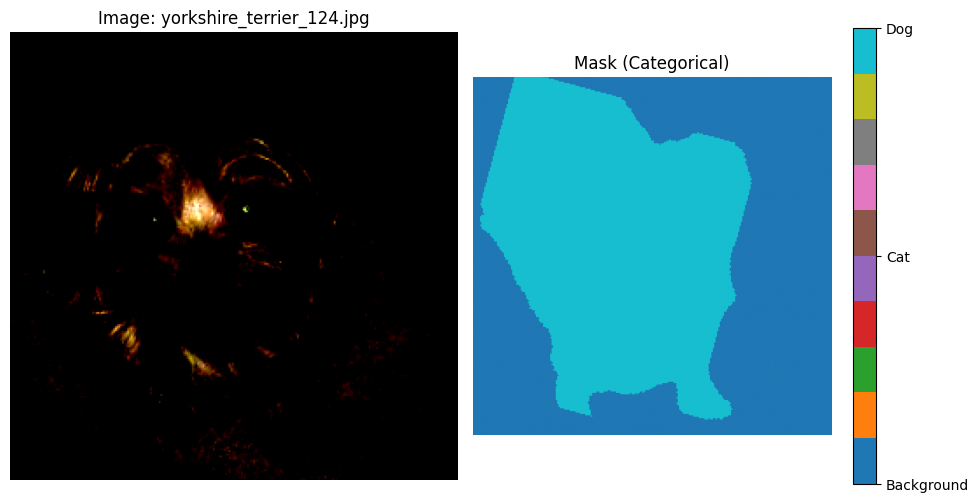


Mask Statistics:
Class 0 (background): 33240 pixels (50.72% of mask)
Class 2 (dog): 32296 pixels (49.28% of mask)


In [2]:
test_path = "./Dataset/Test/color"
test_label_path = "./Dataset/Test/label"
train_path = "./Dataset/TrainVal/color"
train_label_path = "./Dataset/TrainVal/label"

class SegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform: Optional[A.Compose] = None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = os.listdir(image_dir)

        # Define class mapping
        self.class_mapping = {
            0: 'background',
            1: 'cat',
            2: 'dog'
        }

    def __len__(self) -> int:
        return len(self.image_filenames)

    def preprocess_mask(self, mask: np.ndarray) -> np.ndarray:
        """Convert RGB mask to categorical labels.
        Class 0: background (no 128 in any channel)
        Class 1: cat (128 in red channel)
        Class 2: dog (128 in green channel)
        """
        try:
            # Initialize categorical mask
            categorical_mask = np.zeros(mask.shape[:2], dtype=np.uint8)

            # Check if mask is RGB
            if len(mask.shape) != 3:
                raise ValueError(f"Unexpected mask shape {mask.shape}")

            # Cat pixels (128 in red channel)
            cat_pixels = mask[:,:,0] == 128
            categorical_mask[cat_pixels] = 1

            # Dog pixels (128 in green channel)
            dog_pixels = mask[:,:,1] == 128
            categorical_mask[dog_pixels] = 2

            return categorical_mask

        except Exception as e:
            print(f"Error processing mask: {str(e)}")
            return np.zeros(mask.shape[:2], dtype=np.uint8)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        filename = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, filename)
        mask_path = os.path.join(self.mask_dir, filename.replace(".jpg", ".png"))

        # Read image and convert RGBA to RGB if necessary
        image = imread(image_path)
        if image.shape[-1] == 4:  # If RGBA
            image = image[..., :3]  # Keep only RGB channels

        # Read and preprocess mask
        mask = imread(mask_path)
        mask = self.preprocess_mask(mask)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        return image, mask

# Transform pipeline remains the same
transform = A.Compose([
    A.LongestMaxSize(max_size=300, interpolation=0),
    A.PadIfNeeded(min_height=300, min_width=300, border_mode=0),
    A.RandomCrop(256, 256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.ElasticTransform(
        alpha=1.0,
        sigma=50.0,
        interpolation=cv2.INTER_LINEAR,
        approximate=False,
        same_dxdy=False,
        mask_interpolation=cv2.INTER_NEAREST,
        noise_distribution="gaussian",
        keypoint_remapping_method="mask",
        p=0.3
    ),
    A.GridDistortion(p=0.3),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.GaussNoise(
        std_range=(0.1, 0.2),
        mean_range=(0.0, 0.0),
        per_channel=True,
        noise_scale_factor=1.0,
        p=0.2
    ),
    A.CoarseDropout(
        num_holes_range=(3, 6),
        hole_height_range=(10, 20),
        hole_width_range=(10, 20),
        fill="random_uniform",
        p=0.3
    ),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

def visualize_sample(dataset, idx=None):
    """Visualize a sample from the dataset."""
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]
    filename = dataset.image_filenames[idx]

    # Convert tensor to numpy if necessary
    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy()
    else:
        image_np = image

    if isinstance(mask, torch.Tensor):
        mask_np = mask.numpy()
    else:
        mask_np = mask

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Show image
    ax1.imshow(image_np)
    ax1.set_title(f'Image: {filename}')
    ax1.axis('off')

    # Show mask with categorical colormap
    mask_plot = ax2.imshow(mask_np, cmap='tab10', vmin=0, vmax=2)
    ax2.set_title('Mask (Categorical)')
    ax2.axis('off')

    # Add colorbar
    cbar = plt.colorbar(mask_plot, ax=ax2, ticks=[0, 1, 2])
    cbar.set_ticklabels(['Background', 'Cat', 'Dog'])

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nMask Statistics:")
    unique_values = np.unique(mask_np)
    for value in unique_values:
        count = np.sum(mask_np == value)
        percentage = (count / mask_np.size) * 100
        class_name = dataset.class_mapping[value]
        print(f"Class {value} ({class_name}): {count} pixels ({percentage:.2f}% of mask)")

# Create dataset and dataloader
dataset = SegmentationDataset(image_dir=train_path, mask_dir=train_label_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Print dataset information
image, mask = dataset[0]
print(f"Image range: ({image.min():.4f}, {image.max():.4f})")
print(f"Image shape: {image.shape}")
print(f"Mask range: ({mask.min()}, {mask.max()})")
print(f"Mask shape: {mask.shape}")

# Visualize a random sample
visualize_sample(dataset)

### 1.1 Test transformation on a single image

<ipython-input-3-faa5b8763964>:10: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),
<ipython-input-3-faa5b8763964>:12: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),
<ipython-input-3-faa5b8763964>:26: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),


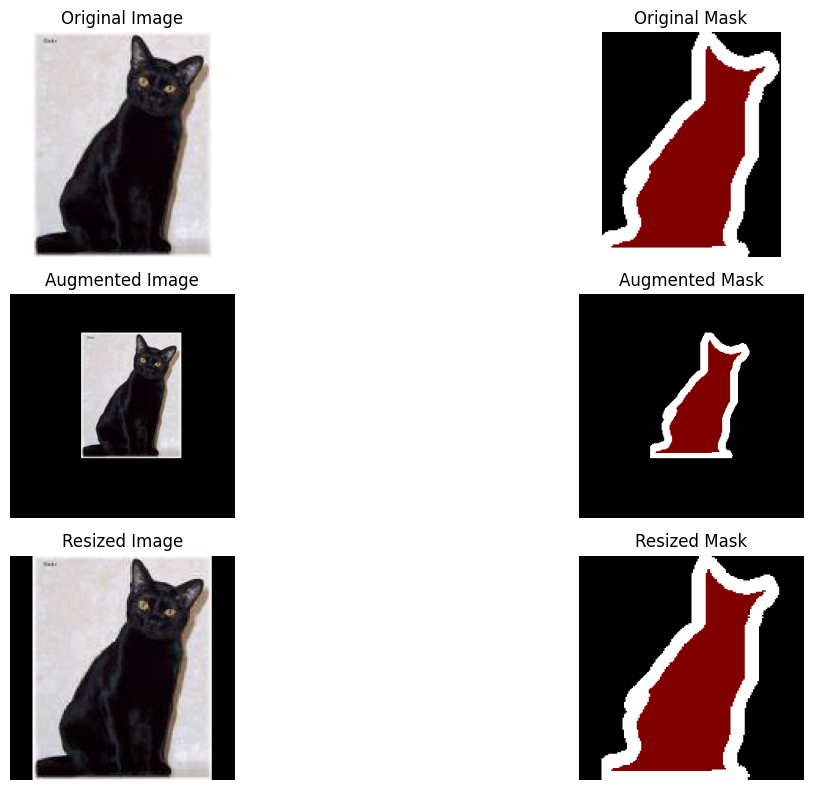

In [3]:
image_test = imread(os.path.join(train_path, "Bombay_103.jpg"))
mask_test = imread(os.path.join(train_label_path, "Bombay_103.png"))

# Convert RGBA to RGB if necessary
if image_test.shape[-1] == 4:
    image_test = image_test[:, :, :3]

# Define the same augmentation pipeline as used in your dataset
transform_test = A.Compose([
    A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),
    A.LongestMaxSize(max_size=300, interpolation=0),
    A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),
    A.RandomCrop(256, 256),
    ToTensorV2()
])

augmented_test = transform_test(image=image_test, mask=mask_test)
aug_image, aug_mask = augmented_test["image"], augmented_test["mask"]

# Convert tensors to NumPy for visualization
aug_image_np = aug_image.permute(1, 2, 0).numpy()
aug_mask_np = aug_mask.numpy()

transform_resize = A.Compose([
    A.LongestMaxSize(max_size=300, interpolation=0),
    A.PadIfNeeded(min_height=300, min_width=300, border_mode=0, value=(0, 0, 0)),
    ToTensorV2()
])

resized = transform_resize(image=image_test, mask=mask_test)
resized_image, resized_mask = resized["image"], resized["mask"]
resized_image_np = resized_image.permute(1, 2, 0).numpy()
resized_mask_np = resized_mask.numpy()

fig, axes = plt.subplots(3, 2, figsize=(15, 8))

# Original Image
axes[0, 0].imshow(image_test)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis("off")

# Original Mask
axes[0, 1].imshow(mask_test, cmap="gray")
axes[0, 1].set_title("Original Mask")
axes[0, 1].axis("off")

# Augmented Image
axes[1, 0].imshow(aug_image_np)
axes[1, 0].set_title("Augmented Image")
axes[1, 0].axis("off")

# Augmented Mask
axes[1, 1].imshow(aug_mask_np, cmap="gray")
axes[1, 1].set_title("Augmented Mask")
axes[1, 1].axis("off")

# Resized Image
axes[2, 0].imshow(resized_image_np)
axes[2, 0].set_title("Resized Image")
axes[2, 0].axis("off")

# Resized Mask
axes[2, 1].imshow(resized_mask_np, cmap="gray")
axes[2, 1].set_title("Resized Mask")
axes[2, 1].axis("off")

plt.tight_layout()
plt.show()


## 2. Segmentation network design and implementation

### 2.A) UNet-based end-to-end segmentation network (optional)

### 2.B) Autoencoder pre-training for segmentation

**Phase A**: Train a reconstruction autoencoder (3-channel output) with MSE.

**Phase B**: Load encoder weights into a segmentation autoencoder (1-channel output) with BCE.

In [4]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### PHASE A) RECONSTRUCTION AUTOENCODER (3-Channel)

In [5]:
class ReconstructionAutoencoder(nn.Module):
    """
    Autoencoder for image reconstruction:
    - 3-channel output (RGB).
    - Uses the same encoder architecture you'll reuse for segmentation.
    """
    def __init__(self):
        super(ReconstructionAutoencoder, self).__init__()
        # Optional: keep normalization buffers for reference
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

        # Encoder (same as below)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 1024),
        )

        # Decoder for reconstruction (3-ch output)
        self.decoder = nn.Sequential(
            nn.Linear(1024, 64 * 32 * 32),
            nn.LeakyReLU(),
            nn.Unflatten(1, (64, 32, 32)),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # 3-channel output

def train_autoencoder_for_reconstruction(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    save_model: str | None = None,
    loss_fn: nn.Module | None = None,
    skip_epoch_stats: bool = False
) -> dict:
    """
    Train the reconstruction autoencoder (Phase A).
    - Loss defaults to MSE or L1 between predicted image and original image.
    """
    if loss_fn is None:
        loss_fn = nn.MSELoss()  # or nn.L1Loss()

    model = model.to(device)
    best_loss = float('inf')
    best_state_dict = None
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        num_batches = 0

        # ignoring the mask, just reconstruct the original image
        for (features, _) in dataloader:
            features = features.to(device, non_blocking=True)

            # forward
            recon = model(features)
            loss = loss_fn(recon, features)

            # backward
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            del features, recon, loss
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        epoch_loss /= num_batches
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if not skip_epoch_stats:
            print(f"Reconstruction Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f}")
        print(f"Time elapsed: {(time.time() - start_time)/60:.2f} min")

    print(f"Total Reconstruction Training Time: {(time.time() - start_time)/60:.2f} min")
    if save_model is not None and best_state_dict is not None:
        torch.save(best_state_dict, save_model)

    return best_state_dict


### PHASE B) SEGMENTATION AUTOENCODER (1-Channel)

In [42]:
class DiceLoss(nn.Module):
    """
    Dice Loss for multi-class segmentation.

    This loss measures the overlap between the predicted segmentation and the ground truth.
    It is particularly useful in cases of class imbalance.

    Attributes:
        smooth (float): A smoothing factor to prevent division by zero.
        ignore_index (Optional[int]): Class index to ignore during loss computation.
    """
    def __init__(self, smooth: float = 1.0, ignore_index: Optional[int] = None) -> None:
        """
        Initialize the DiceLoss module.

        Args:
            smooth (float): Smoothing constant to avoid division by zero. Default is 1.0.
            ignore_index (Optional[int]): Class index to ignore in loss computation. Default is None.
        """
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Compute the Dice loss.

        Args:
            inputs (torch.Tensor): Logits tensor from the network of shape (B, C, H, W).
            targets (torch.Tensor): Ground truth tensor of shape (B, H, W) containing class indices.

        Returns:
            torch.Tensor: A scalar tensor representing the Dice loss.
        """
        num_classes = inputs.shape[1]
        # Convert targets to one-hot encoding of shape (B, H, W, C) then permute to (B, C, H, W)
        targets_one_hot: torch.Tensor = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

        # Apply softmax to obtain probabilities for each class
        inputs_prob: torch.Tensor = torch.softmax(inputs, dim=1)

        # Compute intersection and union along batch and spatial dimensions
        dims = (0, 2, 3)
        intersection: torch.Tensor = torch.sum(inputs_prob * targets_one_hot, dims)
        cardinality: torch.Tensor = torch.sum(inputs_prob + targets_one_hot, dims)

        # Compute the Dice coefficient per class
        dice_score: torch.Tensor = (2.0 * intersection + self.smooth) / (cardinality + self.smooth)

        # Optionally ignore a particular class (e.g., background class 0)
        if self.ignore_index is not None:
            mask: torch.Tensor = torch.ones(num_classes, dtype=torch.bool, device=inputs.device)
            mask[self.ignore_index] = False
            dice_score = dice_score[mask]

        # Dice loss is defined as 1 minus the average Dice score over classes
        loss: torch.Tensor = 1 - dice_score.mean()
        return loss

dice_loss_all: DiceLoss = DiceLoss(smooth=1.0, ignore_index=None)
dice_loss_without_black: DiceLoss = DiceLoss(smooth=1.0, ignore_index=0)

In [43]:
class SegmentationAutoencoder(nn.Module):
    """An autoencoder architecture for multi-class segmentation (3 classes)."""
    def __init__(self):
        super().__init__()
        self.register_buffer(
            'mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        )
        self.register_buffer(
            'std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        )

        # same encoder architecture, but final decoder now has 3-ch output for 3 classes
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(64*32*32, 1024)
        )

        self.decoder = nn.Sequential(
            nn.Linear(1024, 64*32*32),
            nn.LeakyReLU(),
            nn.Unflatten(1, (64, 32, 32)),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1)  # 3 channels for 3 classes
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        # shape: (B,3,H,W)
        return x

def compute_epoch_loss_seg(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module
) -> float:
    """Compute average segmentation loss over an epoch (eval mode). For multi-class."""
    model.eval()
    curr_loss = 0.0
    num_batches = 0
    with torch.no_grad():
        for features, mask in dataloader:
            features = features.to(device, non_blocking=True)
            mask = mask.to(device, non_blocking=True)

            # For cross-entropy, we want mask to be Long type in [0..(num_classes-1)].
            # Our classes are {0,1,2} => 3 classes.
            mask = mask.long()

            outputs = model(features)  # shape: (B,3,H,W)
            loss = loss_fn(outputs, mask)  # cross-entropy expects (B,3,H,W) & (B,H,W)
            curr_loss += loss.item()
            num_batches += 1

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    return curr_loss / num_batches

def train_autoencoder_for_seg(
    model: nn.Module,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    save_model: str = None,
    loss_fn: nn.Module = None,
    skip_epoch_stats: bool = False
) -> dict:
    """Train the segmentation autoencoder for multi-class segmentation with 3 classes."""
    # Use CrossEntropyLoss for multi-class
    if loss_fn is None:
        loss_fn = dice_loss_without_black

    model.to(device)
    best_loss = float('inf')
    best_model_state_dict = None
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        num_batches = 0

        for features, mask in dataloader:
            features = features.to(device, non_blocking=True)
            mask = mask.to(device, non_blocking=True).long()

            # forward
            logits = model(features)  # (B,3,H,W)
            loss = loss_fn(logits, mask)  # cross-entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            del features, logits, loss, mask
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        epoch_loss /= num_batches
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_state_dict = {
                k: v.cpu().clone() for k, v in model.state_dict().items()
            }

        if not skip_epoch_stats:
            val_loss = compute_epoch_loss_seg(model, dataloader, loss_fn)
            print(f"Epoch {epoch+1:03d}/{num_epochs:03d} | Loss: {val_loss:.3f}")

        print(f"Time elapsed: {(time.time() - start_time)/60:.2f} min")

    print(f"Total Training Time: {(time.time() - start_time)/60:.2f} min")

    if save_model and best_model_state_dict:
        torch.save(best_model_state_dict, save_model)

    return best_model_state_dict

### Example Usage
*Phase A: Train reconstruction autoencoder*
*Phase B: Train segmentation autoencoder (re-using encoder weights)*

In [7]:
# Phase A: train reconstruction autoencoder
train_loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

recon_model = ReconstructionAutoencoder().to(device)
optimizer_recon = torch.optim.Adam(recon_model.parameters(), lr=0.001)

print("\n=== PHASE A: Training Reconstruction Autoencoder ===")
recon_best_state = train_autoencoder_for_reconstruction(
    model=recon_model,
    dataloader=train_loader,
    optimizer=optimizer_recon,
    num_epochs=40,
    save_model="recon_model.pt",
    skip_epoch_stats=False
)


=== PHASE A: Training Reconstruction Autoencoder ===
Reconstruction Epoch 1/40 | Loss: 1.7192
Time elapsed: 0.40 min
Reconstruction Epoch 2/40 | Loss: 1.3933
Time elapsed: 0.79 min
Reconstruction Epoch 3/40 | Loss: 1.1059
Time elapsed: 1.19 min
Reconstruction Epoch 4/40 | Loss: 0.8349
Time elapsed: 1.59 min
Reconstruction Epoch 5/40 | Loss: 0.6616
Time elapsed: 2.01 min
Reconstruction Epoch 6/40 | Loss: 0.5919
Time elapsed: 2.42 min
Reconstruction Epoch 7/40 | Loss: 0.5499
Time elapsed: 2.82 min
Reconstruction Epoch 8/40 | Loss: 0.5161
Time elapsed: 3.24 min
Reconstruction Epoch 9/40 | Loss: 0.4865
Time elapsed: 3.65 min
Reconstruction Epoch 10/40 | Loss: 0.4767
Time elapsed: 4.06 min
Reconstruction Epoch 11/40 | Loss: 0.4478
Time elapsed: 4.47 min
Reconstruction Epoch 12/40 | Loss: 0.4303
Time elapsed: 4.88 min
Reconstruction Epoch 13/40 | Loss: 0.4210
Time elapsed: 5.29 min
Reconstruction Epoch 14/40 | Loss: 0.4071
Time elapsed: 5.70 min
Reconstruction Epoch 15/40 | Loss: 0.4014
Tim

In [44]:
print("\n=== PHASE B: TRAINING SEGMENTATION AUTOENCODER (3-class) ===")
seg_model = SegmentationAutoencoder().to(device)

# Use the weights of the reconstruction autoencoder
if recon_best_state is not None:
    seg_state = seg_model.state_dict()
    encoder_keys = [k for k in recon_best_state.keys() if k.startswith('encoder')]
    filtered_dict = {}
    for k in encoder_keys:
        if k in seg_state:
            filtered_dict[k] = recon_best_state[k]

    seg_state.update(filtered_dict)
    seg_model.load_state_dict(seg_state)
    print("Successfully loaded encoder weights from reconstruction.")
else:
    print("[Warning] No reconstruction model weights loaded.")

params = list(seg_model.encoder.parameters())
total_params = len(params)
num_to_freeze = int(total_params * 0.8)

for param in params[:num_to_freeze]:
    param.requires_grad = False

optimizer_seg = torch.optim.Adam(seg_model.parameters(), lr=0.003)

seg_best_model = train_autoencoder_for_seg(
    model=seg_model,
    dataloader=train_loader,
    optimizer=optimizer_seg,
    num_epochs=40,
    save_model="seg_model_2_dice_loss_without_black.pt",
    skip_epoch_stats=False
)

print("\nDone. Phase A (reconstruction) + Phase B (3-class segmentation) complete.")


=== PHASE B: TRAINING SEGMENTATION AUTOENCODER (3-class) ===
Successfully loaded encoder weights from reconstruction.
Epoch 001/040 | Loss: 0.692
Time elapsed: 0.68 min
Epoch 002/040 | Loss: 0.691
Time elapsed: 1.35 min
Epoch 003/040 | Loss: 0.687
Time elapsed: 2.03 min
Epoch 004/040 | Loss: 0.683
Time elapsed: 2.69 min
Epoch 005/040 | Loss: 0.678
Time elapsed: 3.36 min
Epoch 006/040 | Loss: 0.671
Time elapsed: 4.03 min
Epoch 007/040 | Loss: 0.659
Time elapsed: 4.69 min
Epoch 008/040 | Loss: 0.637
Time elapsed: 5.34 min
Epoch 009/040 | Loss: 0.619
Time elapsed: 6.01 min
Epoch 010/040 | Loss: 0.651
Time elapsed: 6.67 min
Epoch 011/040 | Loss: 0.625
Time elapsed: 7.33 min
Epoch 012/040 | Loss: 0.602
Time elapsed: 7.99 min
Epoch 013/040 | Loss: 0.603
Time elapsed: 8.67 min
Epoch 014/040 | Loss: 0.605
Time elapsed: 9.35 min
Epoch 015/040 | Loss: 0.599
Time elapsed: 10.03 min
Epoch 016/040 | Loss: 0.597
Time elapsed: 10.69 min
Epoch 017/040 | Loss: 0.593
Time elapsed: 11.35 min
Epoch 018/0

In [45]:
def get_inference_transform() -> A.Compose:
    """
    Albumentations transform pipeline for inference.
    Resizes the longest side of the image to 256 while preserving aspect ratio,
    pads to 256x256 if needed, normalizes, and converts to a PyTorch tensor.

    :return: Albumentations Compose object with the defined transformations.
    """
    transform = A.Compose([
        # Resize the longest side to 256 (maintains aspect ratio).
        A.LongestMaxSize(
            max_size=256,
            interpolation=cv2.INTER_LINEAR
        ),
        # Pad to exactly 256x256, if one dimension < 256.
        A.PadIfNeeded(min_height=256, min_width=256, border_mode=0),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
        # Finally, convert image & mask to PyTorch tensor.
        ToTensorV2()
    ])
    return transform

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test_reconstruction(model: nn.Module, dataset: SegmentationDataset, num_samples: int = 2) -> None:
    """
    Pass random images through the reconstruction autoencoder,
    visualize the original vs. reconstructed outputs side by side.
    """
    model.eval()
    for _ in range(num_samples):
        idx = random.randint(0, len(dataset) - 1)

        # 'image' is already a tensor of shape (3, H, W) after Albumentations + ToTensorV2
        image, _ = dataset[idx]  # ignoring the mask for reconstruction

        # Add a batch dimension and move to device
        image_in = image.unsqueeze(0).to(device)  # shape: (1, 3, H, W)

        with torch.no_grad():
            recon_out = model(image_in)  # shape: (1, 3, H, W)

        # Move both original and reconstructed to CPU for visualization
        # Original image: (3, H, W) -> (H, W, 3)
        image_np = image.permute(1, 2, 0).cpu().numpy()
        # Reconstruction: (1, 3, H, W) -> (3, H, W) -> (H, W, 3)
        recon_np = recon_out.squeeze(0).permute(1, 2, 0).cpu().numpy()

        # Often, recon might be outside [0, 1], so let's clamp
        recon_np = np.clip(recon_np, 0, 1)

        # Plot side by side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(image_np)
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        axes[1].imshow(recon_np)
        axes[1].set_title('Reconstructed')
        axes[1].axis('off')

        plt.show()

# Create the transform pipeline
test_transform = get_inference_transform()

# Create the test dataset with the transform
test_dataset = SegmentationDataset(
    image_dir="./Dataset/Test/color",
    mask_dir="./Dataset/Test/label",
    transform=test_transform
)



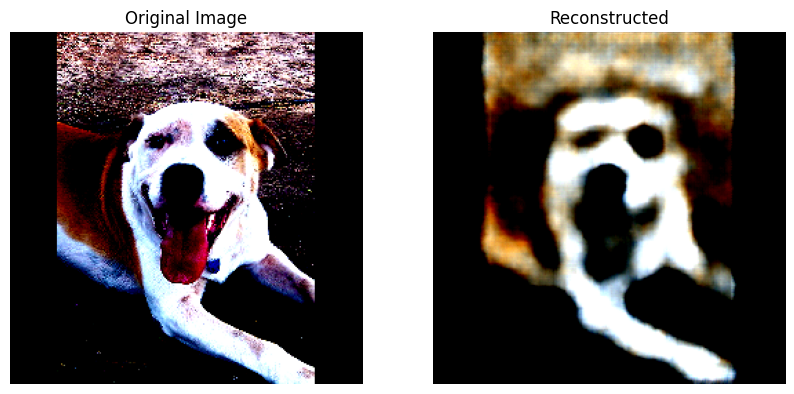

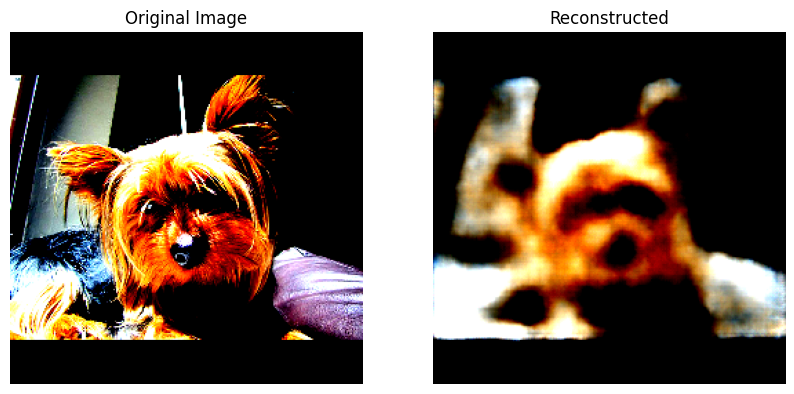

In [50]:
# Suppose 'recon_model' is your trained reconstruction network
test_reconstruction(recon_model, test_dataset, num_samples=2)

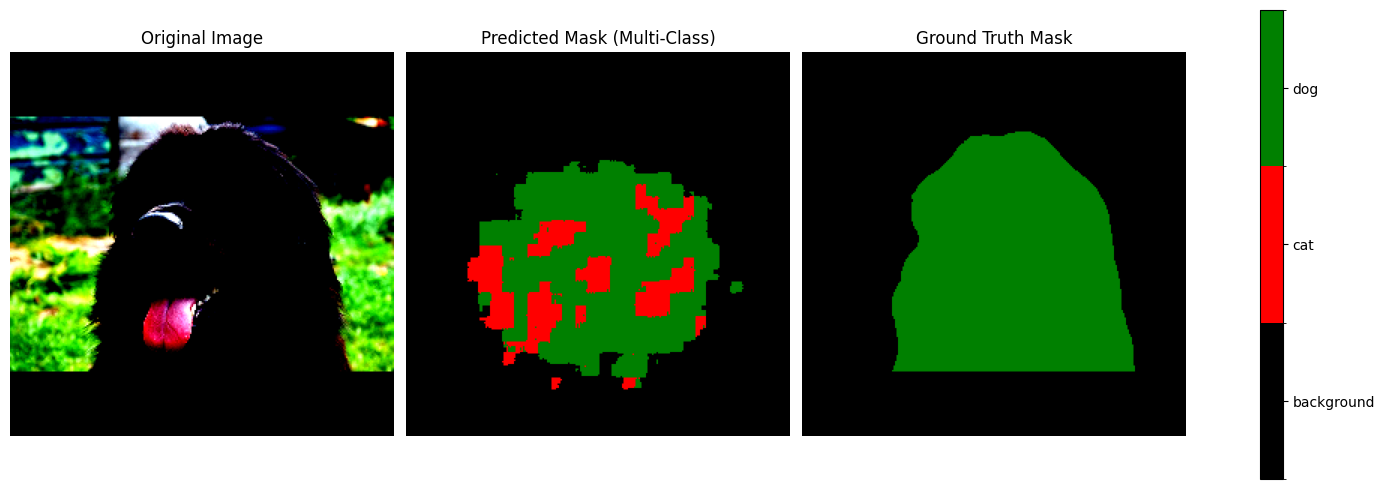

Image index: 1731
Image shape: (3, 256, 256); range=(-2.118, 2.309)
Pred mask shape: (256, 256); unique classes: [0 1 2]
GT mask shape: (256, 256); unique classes: [0 2]



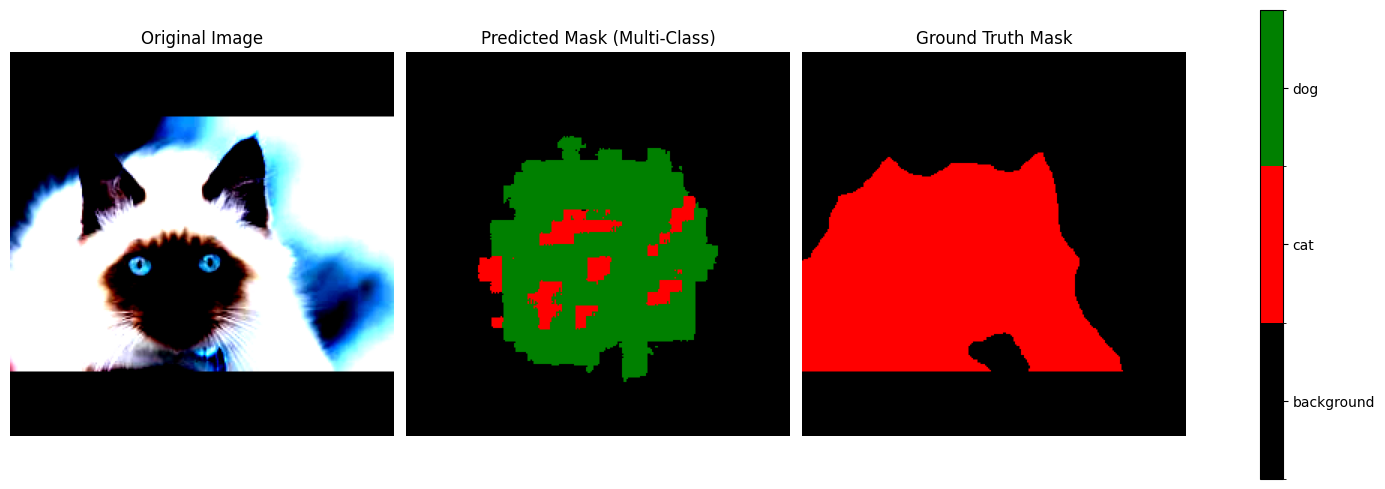

Image index: 1915
Image shape: (3, 256, 256); range=(-2.118, 2.640)
Pred mask shape: (256, 256); unique classes: [0 1 2]
GT mask shape: (256, 256); unique classes: [0 1]



In [54]:
def test_segmentation(
    model: nn.Module,
    dataset: SegmentationDataset,
    num_samples: int = 2,
    class_map: Optional[Dict[int, str]] = None
) -> None:
    """
    Pass random images from 'dataset' through the segmentation 'model',
    then visualize the original image, predicted mask, and ground truth mask.
    This version is for *multi-class* segmentation.

    We assume the model outputs a tensor of shape (B, num_classes, H, W).
    We apply an argmax along the channel dimension to select the most likely
    class ID per pixel.

    :param model: A PyTorch segmentation model (e.g., a multi-class UNet).
    :param dataset: A SegmentationDataset returning (image_tensor, mask_tensor).
    :param num_samples: Number of random samples to visualize.
    :param class_map: Optional dictionary mapping class IDs to class names,
                      e.g. {0: 'background', 1: 'cat', 2: 'dog'}.
    """
    # If no mapping is given, label them "Class 0", "Class 1", etc.
    if class_map is None:
        class_map = {}

    model.eval()

    for _ in range(num_samples):
        idx: int = random.randint(0, len(dataset) - 1)

        # image shape: (C, H, W), mask shape: (H, W) after your transforms
        image, mask = dataset[idx]

        # Add batch dimension, move to device -> (1, C, H, W)
        image_in: torch.Tensor = image.unsqueeze(0).to(device)

        # Forward pass (inference)
        with torch.no_grad():
            # logits shape: (1, num_classes, H, W)
            logits: torch.Tensor = model(image_in)

        # Argmax along the channel dimension: shape -> (1, H, W)
        pred_mask: torch.Tensor = torch.argmax(logits, dim=1)

        # Remove batch dimension -> shape: (H, W)
        pred_mask_np: np.ndarray = pred_mask.squeeze(0).cpu().numpy()

        # Convert original image (C,H,W) -> (H,W,C) for plotting
        image_np: np.ndarray = image.permute(1, 2, 0).cpu().numpy()

        # Ground truth mask as NumPy
        gt_mask_np: np.ndarray = mask.cpu().numpy()

        # -----------------------------
        # Create discrete color map
        # -----------------------------
        # We'll figure out how many classes we need based on the highest class ID
        max_class_id = max(int(pred_mask_np.max()), int(gt_mask_np.max()))
        # Example color list with enough colors (expand if needed)
        color_list = [
            "black",   # class 0
            "red",     # class 1
            "green",   # class 2
        ]
        # Use as many as classes we need
        cmap = mcolors.ListedColormap(color_list[:max_class_id+1], name="MultiClassMap")
        # Boundary norm so each integer class ID maps to a distinct color
        bounds = list(range(max_class_id + 2))  # e.g. [0,1,2,...,max_class_id+1]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

        # -----------------------------
        # Plotting
        # -----------------------------
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original Image
        axes[0].imshow(image_np.clip(0, 1))  # clamp if needed for display
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        # Predicted mask (categorical)
        im_pred = axes[1].imshow(pred_mask_np, cmap=cmap, norm=norm)
        axes[1].set_title("Predicted Mask (Multi-Class)")
        axes[1].axis("off")

        # Ground truth mask (categorical)
        im_gt = axes[2].imshow(gt_mask_np, cmap=cmap, norm=norm)
        axes[2].set_title("Ground Truth Mask")
        axes[2].axis("off")

        plt.tight_layout()

        # Create color bar on the right for the last subplot
        cbar = plt.colorbar(im_gt, ax=axes, location='right',
                            ticks=[x + 0.5 for x in range(max_class_id+1)])
        # Map tick labels to class_map if provided
        tick_labels = [
            class_map.get(i, f"Class {i}") for i in range(max_class_id + 1)
        ]
        cbar.set_ticklabels(tick_labels)

        plt.show()

        # -----------------------------
        # Print some quick stats
        # -----------------------------
        print(f"Image index: {idx}")
        print(f"Image shape: {tuple(image.shape)}; range=({image_np.min():.3f}, {image_np.max():.3f})")
        print(f"Pred mask shape: {pred_mask_np.shape}; unique classes: {np.unique(pred_mask_np)}")
        print(f"GT mask shape: {gt_mask_np.shape}; unique classes: {np.unique(gt_mask_np)}\n")


# -----------------------------
# Example usage:
# -----------------------------
# Suppose you have a segmentation model for 3 classes: 0=background,1=cat,2=dog
class_map_dict = {0: "background", 1: "cat", 2: "dog"}
test_segmentation(seg_model, test_dataset, num_samples=2, class_map=class_map_dict)

In [55]:
def evaluate_segmentation(
    model: nn.Module,
    dataset: torch.utils.data.Dataset,
    num_classes: int,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    batch_size: int = 4
) -> None:
    """
    Evaluate a multi-class segmentation model on a given dataset, computing per-class
    Dice scores and IoU (Jaccard) indices.

    :param model: A PyTorch segmentation model that outputs (B, num_classes, H, W) logits.
    :param dataset: A dataset returning (image_tensor, mask_tensor), where:
                    - image_tensor.shape == (C, H, W)
                    - mask_tensor.shape == (H, W) with integer class IDs.
    :param num_classes: Number of classes (including background).
    :param device: The device (CPU or GPU) on which to perform evaluation.
    :param batch_size: Batch size for the DataLoader.
    """
    # Create a DataLoader for the test dataset
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Initialize accumulators for TP, FP, FN for each class
    #   TP[c] = # of pixels correctly predicted as class c
    #   FP[c] = # of pixels wrongly predicted as class c
    #   FN[c] = # of pixels missed as class c
    TP = [0] * num_classes
    FP = [0] * num_classes
    FN = [0] * num_classes

    model.eval()
    with torch.no_grad():
        for images, targets in loader:
            # images.shape = (B, C, H, W), targets.shape = (B, H, W)
            images = images.to(device)
            targets = targets.to(device)

            # Forward pass -> logits: (B, num_classes, H, W)
            logits = model(images)
            # Get predicted classes via argmax: (B, H, W)
            preds = torch.argmax(logits, dim=1)

            # For each class, accumulate TP, FP, FN
            # We'll treat each image in the batch separately
            for b in range(images.size(0)):
                pred_b = preds[b]   # shape (H, W)
                target_b = targets[b]  # shape (H, W)

                for c in range(num_classes):
                    # Boolean masks
                    pred_c = (pred_b == c)
                    target_c = (target_b == c)

                    # True Positive: pixels where pred == c AND target == c
                    TP[c] += (pred_c & target_c).sum().item()

                    # False Positive: pixels where pred == c AND target != c
                    FP[c] += (pred_c & (~target_c)).sum().item()

                    # False Negative: pixels where pred != c AND target == c
                    FN[c] += ((~pred_c) & target_c).sum().item()

    # Compute Dice Score and IoU per class
    dice_scores: List[float] = []
    iou_scores: List[float] = []

    for c in range(num_classes):
        # Dice = 2 * TP / (2*TP + FP + FN)
        # IoU  = TP / (TP + FP + FN)
        tp = TP[c]
        fp = FP[c]
        fn = FN[c]

        dice = 2.0 * tp / (2.0 * tp + fp + fn) if (2*tp + fp + fn) > 0 else 0.0
        iou  = float(tp) / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

        dice_scores.append(dice)
        iou_scores.append(iou)

    # Print results
    print("Evaluation Results:")
    for c in range(num_classes):
        print(f"Class {c}: Dice = {dice_scores[c]:.4f}, IoU = {iou_scores[c]:.4f}")

    # Optionally, compute mean over all classes except background if you prefer
    # For example, if class 0 is background, we can average classes [1..num_classes-1]
    mean_dice = np.mean(dice_scores[1:]) if num_classes > 1 else dice_scores[0]
    mean_iou  = np.mean(iou_scores[1:]) if num_classes > 1 else iou_scores[0]
    print(f"\nMean Dice (excluding class 0): {mean_dice:.4f}")
    print(f"Mean IoU  (excluding class 0): {mean_iou:.4f}")


num_classes = 3

# Evaluate
evaluate_segmentation(seg_model, test_dataset, num_classes=num_classes)

Evaluation Results:
Class 0: Dice = 0.8636, IoU = 0.7600
Class 1: Dice = 0.3570, IoU = 0.2173
Class 2: Dice = 0.4429, IoU = 0.2844

Mean Dice (excluding class 0): 0.3999
Mean IoU  (excluding class 0): 0.2509


In [40]:
print(f"Mean dice without exclude class 0: {(0.8921+0.3550+0.4833)/3}")
print(f"Mean IoU without exclude class 0: {(0.8052 + 0.2158 + 0.3187)/3}")

Mean dice without exclude class 0: 0.5768000000000001
Mean IoU without exclude class 0: 0.4465666666666666
